LOG WRITER DIMENSIONS

To look at full dataframe -> print(df) <br>
To look at seperated dataframe -> print(dfs)/print(dict['df_(dataframe number)']) <br>
To look at rank scores -> print(rank_dataframe)

In [3]:
# WRITING THE LOG
import pandas as pd

# file_format = ['csv', 'avro', 'parquet', 'orc']
# schemas = ['st','vt', 'pt', 'extvt', 'wpt']
# partition = ['horizontal','predicate', 'subject']

print('Dimension Type:')
dimension = input()

file_format = []
schemas = []
partition = []

# take file format input
print("File Format: ")
while True:
    line = input()
    if line:
        file_format.append(line)
    else:
        break

# take schemas input
print("Schemas: ")
while True:
    line = input()
    if line:
        schemas.append(line)
    else:
        break

# take partition input
print("Partition: ")
while True:
    line = input()
    if line:
        partition.append(line)
    else:
        break

if dimension == 'storage': 
    idx = []
    li=[]
    # READ LOG - STORAGE FORMAT
    for i in schemas:
        for j in partition:
            for k in file_format:
                # check folder
                print(f'./logs/{k}/100M_{i}_{j}.txt')

                df = pd.read_csv(f'./logs/{k}/100M_{i}_{j}.txt',sep = ',', header = None)
                df = df.fillna(0)
                avg = df.mean(axis = 0)
                li.append(avg)
                idx.append(k + f"_{i}_{j}")

    # create dataframe
    df = pd.DataFrame(li, index = [idx])
    df = df.set_axis(["Q"+str(i+1) for i in range(11)], axis = 1)
    df = df.fillna(5000)
    # split dataframe
    dict = {}
    count = 0
    loop = len(file_format)
    dfs = []
    for i in range(int(len(partition) * len(file_format) * len(schemas) / len(file_format))):
        dict['df_{}'.format(i)] = df[count:loop]
        count = loop
        loop = loop+len(file_format)
        dfs.append(dict[f'df_{i}'])

    # CREATE RANK OCCURENCES
    import scipy.stats as ss
    import numpy as np

    rank_dataframe = []

    for x in dfs:
        df_ranks = x.T
        column_names = df_ranks.columns.to_numpy().tolist()
        column_names = [column_names for column_names, in column_names]
        
        df_ranks_occurences = []
        for index, row in df_ranks.iterrows():
            df_ranks_occurences.append(ss.rankdata(row, method = 'max'))

        df_ranks_occurences = pd.DataFrame(df_ranks_occurences)

        df_transpose = df_ranks_occurences.transpose()

        rank_table = []
        for index, row in df_transpose.iterrows():
            result_row = np.zeros(len(df_transpose.index))
            for i in range(len(row)):
                result_row[int(row[i])-1] +=1
            rank_table.append(result_row)

        rank_table = pd.DataFrame(rank_table)
        rank_table = rank_table.set_axis(column_names, axis = 'index')
        rank_table = rank_table.set_axis([i+1 for i in range(len(column_names))], axis='columns')

        # CREATE R SCORE
        q = 11
        d = len(rank_table.index)

        rank_score = []
        for index, row in rank_table.iterrows():
            s = 0
            for r in range(d):  
                s = s + (row[r+1]*(d-(r+1)) / (q*(d-1)) )
            rank_score.append(s)
        rank_score = pd.DataFrame(rank_score)
        rank_score = rank_score.set_axis(column_names, axis = 'index')
        rank_score = rank_score.set_axis(['Result'], axis='columns')
        rank_score = pd.concat([rank_table, rank_score], axis = 1)
        rank_dataframe.append(rank_score)
####################################################################################################
elif dimension == 'schema':
    idx = []
    li=[]
    # READ LOG - STORAGE FORMAT
    for j in partition:
        for k in file_format:
            for i in schemas:
                # check folder
                print(f'./logs/{k}/100M_{i}_{j}.txt')

                df = pd.read_csv(f'./logs/{k}/100M_{i}_{j}.txt',sep = ',', header = None)
                df = df.fillna(0)
                avg = df.mean(axis = 0)
                li.append(avg)
                idx.append(k + f"_{i}_{j}")

    # create dataframe
    df = pd.DataFrame(li, index = [idx])
    df = df.set_axis(["Q"+str(i+1) for i in range(11)], axis = 1)
    df = df.fillna(5000)
    # split dataframe
    dict = {}
    count = 0
    loop = len(schemas)
    dfs = []
    for i in range(int(len(partition) * len(file_format) * len(schemas) / len(schemas))):
        dict['df_{}'.format(i)] = df[count:loop]
        count = loop
        loop = loop+len(schemas)
        dfs.append(dict[f'df_{i}'])

    # CREATE RANK OCCURENCES
    import scipy.stats as ss
    import numpy as np

    rank_dataframe = []

    for x in dfs:
        df_ranks = x.T
        column_names = df_ranks.columns.to_numpy().tolist()
        column_names = [column_names for column_names, in column_names]
        
        df_ranks_occurences = []
        for index, row in df_ranks.iterrows():
            df_ranks_occurences.append(ss.rankdata(row, method = 'max'))

        df_ranks_occurences = pd.DataFrame(df_ranks_occurences)

        df_transpose = df_ranks_occurences.transpose()

        rank_table = []
        for index, row in df_transpose.iterrows():
            result_row = np.zeros(len(df_transpose.index))
            for i in range(len(row)):
                result_row[int(row[i])-1] +=1
            rank_table.append(result_row)

        rank_table = pd.DataFrame(rank_table)
        rank_table = rank_table.set_axis(column_names, axis = 'index')
        rank_table = rank_table.set_axis([i+1 for i in range(len(column_names))], axis='columns')

        # CREATE R SCORE
        q = 11
        d = len(rank_table.index)

        rank_score = []
        for index, row in rank_table.iterrows():
            s = 0
            for r in range(d):  
                s = s + (row[r+1]*(d-(r+1)) / (q*(d-1)) )
            rank_score.append(s)
        rank_score = pd.DataFrame(rank_score)
        rank_score = rank_score.set_axis(column_names, axis = 'index')
        rank_score = rank_score.set_axis(['Result'], axis='columns')
        rank_score = pd.concat([rank_table, rank_score], axis = 1)
        rank_dataframe.append(rank_score)
########################################################################################################
elif dimension == 'partition':
    idx = []
    li=[]
    # READ LOG - STORAGE FORMAT
    for i in schemas:
        for k in file_format:
            for j in partition:
                # check folder
                print(f'./logs/{k}/100M_{i}_{j}.txt')

                df = pd.read_csv(f'./logs/{k}/100M_{i}_{j}.txt',sep = ',', header = None)
                df = df.fillna(0)
                avg = df.mean(axis = 0)
                li.append(avg)
                idx.append(k + f"_{i}_{j}")

    # create dataframe
    df = pd.DataFrame(li, index = [idx])
    df = df.set_axis(["Q"+str(i+1) for i in range(11)], axis = 1)
    df = df.fillna(5000)
    # split dataframe
    dict = {}
    count = 0
    loop = len(partition)
    dfs = []
    for i in range(int(len(partition) * len(file_format) * len(schemas) / len(partition))):
        dict['df_{}'.format(i)] = df[count:loop]
        count = loop
        loop = loop+len(partition)
        dfs.append(dict[f'df_{i}'])

    # CREATE RANK OCCURENCES
    import scipy.stats as ss
    import numpy as np

    rank_dataframe = []

    for x in dfs:
        df_ranks = x.T
        column_names = df_ranks.columns.to_numpy().tolist()
        column_names = [column_names for column_names, in column_names]
        
        df_ranks_occurences = []
        for index, row in df_ranks.iterrows():
            df_ranks_occurences.append(ss.rankdata(row, method = 'max'))

        df_ranks_occurences = pd.DataFrame(df_ranks_occurences)

        df_transpose = df_ranks_occurences.transpose()

        rank_table = []
        for index, row in df_transpose.iterrows():
            result_row = np.zeros(len(df_transpose.index))
            for i in range(len(row)):
                result_row[int(row[i])-1] +=1
            rank_table.append(result_row)

        rank_table = pd.DataFrame(rank_table)
        rank_table = rank_table.set_axis(column_names, axis = 'index')
        rank_table = rank_table.set_axis([i+1 for i in range(len(column_names))], axis='columns')

        # CREATE R SCORE
        q = 11
        d = len(rank_table.index)

        rank_score = []
        for index, row in rank_table.iterrows():
            s = 0
            for r in range(d):  
                s = s + (row[r+1]*(d-(r+1)) / (q*(d-1)) )
            rank_score.append(s)
        rank_score = pd.DataFrame(rank_score)
        rank_score = rank_score.set_axis(column_names, axis = 'index')
        rank_score = rank_score.set_axis(['Result'], axis='columns')
        rank_score = pd.concat([rank_table, rank_score], axis = 1)
        rank_dataframe.append(rank_score)

else:
    print("choose 'storage' or 'partition' or 'schema' dimension")

Dimension Type:
File Format: 
Schemas: 
Partition: 
./logs/avro/100M_st_horizontal.txt
./logs/csv/100M_st_horizontal.txt
./logs/orc/100M_st_horizontal.txt
./logs/parquet/100M_st_horizontal.txt
./logs/avro/100M_st_subject.txt
./logs/csv/100M_st_subject.txt
./logs/orc/100M_st_subject.txt
./logs/parquet/100M_st_subject.txt
./logs/avro/100M_st_predicate.txt
./logs/csv/100M_st_predicate.txt
./logs/orc/100M_st_predicate.txt
./logs/parquet/100M_st_predicate.txt
./logs/avro/100M_vt_horizontal.txt
./logs/csv/100M_vt_horizontal.txt
./logs/orc/100M_vt_horizontal.txt
./logs/parquet/100M_vt_horizontal.txt
./logs/avro/100M_vt_subject.txt
./logs/csv/100M_vt_subject.txt
./logs/orc/100M_vt_subject.txt
./logs/parquet/100M_vt_subject.txt
./logs/avro/100M_vt_predicate.txt
./logs/csv/100M_vt_predicate.txt
./logs/orc/100M_vt_predicate.txt
./logs/parquet/100M_vt_predicate.txt
./logs/avro/100M_pt_horizontal.txt
./logs/csv/100M_pt_horizontal.txt
./logs/orc/100M_pt_horizontal.txt
./logs/parquet/100M_pt_horizont

In [11]:
df

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11
avro_st_horizontal,34.927520,79.977400,12.211584,175.171868,44.462770,52.109702,94.447627,130.898701,41.511777,10.192575,5.348119
csv_st_horizontal,49.608458,168.670828,32.021346,232.845823,93.884036,98.338989,146.522541,172.249262,71.971304,28.628432,14.293006
orc_st_horizontal,27.277521,58.011053,6.502544,171.147992,32.488883,43.339918,72.468041,127.247422,31.657362,2.437929,1.397683
parquet_st_horizontal,24.956528,57.742420,6.941551,169.987462,33.468086,47.166969,74.262720,131.645367,33.855555,4.247113,1.679916
avro_st_subject,32.731082,74.622292,10.784294,176.796160,43.524238,46.939082,78.333957,129.029052,39.908803,9.719052,5.472666
csv_st_subject,49.156754,164.268452,30.892680,224.434185,92.656595,97.662032,135.019618,169.167089,67.084914,28.741733,14.048996
orc_st_subject,25.179746,49.554490,5.261027,163.969394,29.429456,38.460815,66.309928,119.316469,28.582187,1.816305,1.354175
parquet_st_subject,23.629353,52.787333,6.498906,168.208707,32.358905,40.035283,71.828765,125.427927,29.789882,2.248877,2.123283
avro_st_predicate,34.304236,83.104543,15.365246,219.098707,50.710388,49.289990,72.772159,168.557376,52.768091,14.036328,6.853535
csv_st_predicate,46.328714,162.910559,30.129734,257.723918,89.096152,99.126137,127.746529,180.134653,62.699387,42.271251,14.207328


Save to excel for better view

In [4]:
# Create excel sheet
excel_table = dfs+rank_dataframe
xlwriter = pd.ExcelWriter('~/Desktop/rank_table.xlsx', engine='xlsxwriter')
row = 0
for dataframe in excel_table:
        dataframe.to_excel(xlwriter, sheet_name = 'schema_format_100M', startrow = row, startcol = 0)
        row = row + len(dataframe.index) + 2 
xlwriter.save()

CALCULATING THE CONFORMANCE

df_full_ranks : full dataframe of configurations and their ranks <br>
best_scores :  best 5 configurations from dataframe

In [12]:
# GET FULL RANKS OF DATAFRAME FOR CRITERIA TABLE
df_full_ranks = []
df = df.T
for index, row in df.iterrows():
    df_full_ranks.append(ss.rankdata(row, method = 'max'))

df_full_ranks = pd.DataFrame(df_full_ranks)
df_full_ranks = df_full_ranks.T
df_full_ranks = df_full_ranks.set_axis(df.columns, axis = 'index') #configurations
df_full_ranks = df_full_ranks.set_axis([i+1 for i in range(len(df.index))], axis='columns') #query

In [13]:
# GET BEST SCORES OF 5
full_ranks_scores = pd.concat(rank_dataframe, axis = 0)
full_ranks_scores = full_ranks_scores['Result']
best_scores = full_ranks_scores.nlargest(5)

In [21]:
best_scores

orc_st_subject           0.969697
orc_st_predicate         0.969697
orc_st_horizontal        0.909091
parquet_vt_subject       0.787879
parquet_extvt_subject    0.757576
Name: Result, dtype: float64

In [24]:
best_scores = best_scores.index.to_numpy().tolist()
criteria_table = df_full_ranks.loc[best_scores]
criteria_table

,1,2,3,4,5,6,7,8,9,10,11
orc_st_subject,29,30,21,9,25,38,33,33,30,11,14
orc_st_predicate,36,37,41,30,37,42,34,53,39,25,9
orc_st_horizontal,34,45,30,13,33,43,36,40,33,15,15
parquet_vt_subject,12,25,13,46,8,11,5,34,44,19,2
parquet_extvt_subject,19,9,7,32,11,14,42,19,8,2,60


In [25]:
criteria_table = criteria_table[criteria_table > 15]
criteria_table

,1,2,3,4,5,6,7,8,9,10,11
orc_st_subject,29.0,30.0,21.0,NaN,25.0,38.0,33.0,33,30.0,NaN,NaN
orc_st_predicate,36.0,37.0,41.0,30.0,37.0,42.0,34.0,53,39.0,25.0,NaN
orc_st_horizontal,34.0,45.0,30.0,NaN,33.0,43.0,36.0,40,33.0,NaN,NaN
parquet_vt_subject,NaN,25.0,NaN,46.0,NaN,NaN,NaN,34,44.0,19.0,NaN
parquet_extvt_subject,19.0,NaN,NaN,32.0,NaN,NaN,42.0,19,NaN,NaN,60.0


In [29]:
count = criteria_table.count(axis=1)
avg = count.mean(axis = 0)
count, avg

(orc_st_subject            8
 orc_st_predicate         10
 orc_st_horizontal         8
 parquet_vt_subject        5
 parquet_extvt_subject     5
 dtype: int64,
 7.2)

In [30]:
# GET CONFORMANCE
sum = count.sum(axis = 0)
conformance = 1 - (sum/55)
conformance

0.34545454545454546

PARETO CALCULATION - Finding the non-dominated solution from these3 dimensions

In [31]:
dimensionsAll = df_full_ranks.reset_index().values
dimensionsAll

array([['avro_st_horizontal', 47, 48, 44, 17, 48, 51, 41, 46, 38, 31, 19],
       ['csv_st_horizontal', 51, 56, 56, 38, 56, 55, 54, 54, 45, 34, 24],
       ['orc_st_horizontal', 34, 45, 30, 13, 33, 43, 36, 40, 33, 15, 15],
       ['parquet_st_horizontal', 28, 44, 32, 12, 36, 45, 38, 47, 34, 23,
        16],
       ['avro_st_subject', 45, 47, 42, 19, 47, 44, 39, 42, 37, 30, 20],
       ['csv_st_subject', 50, 55, 55, 36, 55, 54, 52, 52, 43, 35, 22],
       ['orc_st_subject', 29, 30, 21, 9, 25, 38, 33, 33, 30, 11, 14],
       ['parquet_st_subject', 24, 40, 29, 10, 32, 40, 35, 38, 31, 13, 17],
       ['avro_st_predicate', 46, 49, 48, 35, 50, 47, 37, 51, 40, 33, 21],
       ['csv_st_predicate', 49, 54, 54, 41, 54, 56, 51, 55, 42, 36, 23],
       ['orc_st_predicate', 36, 37, 41, 30, 37, 42, 34, 53, 39, 25, 9],
       ['parquet_st_predicate', 37, 46, 49, 40, 51, 53, 40, 56, 41, 32,
        18],
       ['avro_vt_horizontal', 23, 23, 17, 51, 24, 22, 4, 45, 56, 21, 6],
       ['csv_vt_horizontal

In [32]:
dimensions = np.array(df_full_ranks[:], dtype = np.float64)
dimensions

array([[47., 48., 44., 17., 48., 51., 41., 46., 38., 31., 19.],
       [51., 56., 56., 38., 56., 55., 54., 54., 45., 34., 24.],
       [34., 45., 30., 13., 33., 43., 36., 40., 33., 15., 15.],
       [28., 44., 32., 12., 36., 45., 38., 47., 34., 23., 16.],
       [45., 47., 42., 19., 47., 44., 39., 42., 37., 30., 20.],
       [50., 55., 55., 36., 55., 54., 52., 52., 43., 35., 22.],
       [29., 30., 21.,  9., 25., 38., 33., 33., 30., 11., 14.],
       [24., 40., 29., 10., 32., 40., 35., 38., 31., 13., 17.],
       [46., 49., 48., 35., 50., 47., 37., 51., 40., 33., 21.],
       [49., 54., 54., 41., 54., 56., 51., 55., 42., 36., 23.],
       [36., 37., 41., 30., 37., 42., 34., 53., 39., 25.,  9.],
       [37., 46., 49., 40., 51., 53., 40., 56., 41., 32., 18.],
       [23., 23., 17., 51., 24., 22.,  4., 45., 56., 21.,  6.],
       [ 6., 27., 34., 47., 41., 32.,  8., 44., 48., 28., 11.],
       [20., 24., 10., 52., 23., 18.,  2., 39., 53., 14.,  1.],
       [13., 19., 19., 48., 10., 15.,  3

In [33]:
def nsga2(inputPoints, dominates):
    paretoPoints = set()
    candidateRowNr = 0
    dominatedPoints = set()
    while True:
        candidateRow = inputPoints[candidateRowNr] # masuk row pertama
        inputPoints.remove(candidateRow) # buang row pertamanya
        rowNr = 0
        nonDominated = True # row kandidat yg baru masuk di set true buat non dominated nya
        while len(inputPoints) != 0 and rowNr < len(inputPoints):
            row = inputPoints[rowNr] # ambil row lanjutannya
            if dominates(candidateRow, row): # ngecek row kandidat ama row lanjutan di input_point dominasinya
                # If it is worse on all features remove the row from the array
                inputPoints.remove(row)
                dominatedPoints.add(tuple(row))
            elif dominates(row, candidateRow):
                nonDominated = False
                dominatedPoints.add(tuple(candidateRow))
                rowNr += 1
            else:
                rowNr += 1

        if nonDominated:
            # add the non-dominated point to the Pareto frontier
            paretoPoints.add(tuple(candidateRow))

        if len(inputPoints) == 0:
            break
    return paretoPoints, dominatedPoints

In [34]:
def dominates(row, candidateRow):
    return np.sum([row[x] <= candidateRow[x] for x in range(len(row))]) == len(row)    # kalo lebih kecil semua berarti dominasi

inputPoints = dimensions.tolist()
type(inputPoints)
paretoPoints, dominatedPoints = nsga2(inputPoints, dominates)

print ("*"*8 + " non-dominated answers " + ("*"*8) )
for p in paretoPoints:
    print (p)
print ("*"*8 + " dominated answers " + ("*"*8))
for p in dominatedPoints:
    print (p)

******** non-dominated answers ********
(23.0, 23.0, 17.0, 51.0, 24.0, 22.0, 4.0, 45.0, 56.0, 21.0, 6.0)
(36.0, 37.0, 41.0, 30.0, 37.0, 42.0, 34.0, 53.0, 39.0, 25.0, 9.0)
(7.0, 39.0, 33.0, 45.0, 26.0, 25.0, 9.0, 35.0, 49.0, 26.0, 13.0)
(14.0, 20.0, 25.0, 56.0, 39.0, 41.0, 16.0, 50.0, 50.0, 16.0, 12.0)
(20.0, 24.0, 10.0, 52.0, 23.0, 18.0, 2.0, 39.0, 53.0, 14.0, 1.0)
(29.0, 30.0, 21.0, 9.0, 25.0, 38.0, 33.0, 33.0, 30.0, 11.0, 14.0)
(31.0, 16.0, 37.0, 37.0, 9.0, 19.0, 45.0, 21.0, 9.0, 5.0, 60.0)
(8.0, 12.0, 38.0, 39.0, 35.0, 28.0, 50.0, 32.0, 21.0, 10.0, 60.0)
(24.0, 40.0, 29.0, 10.0, 32.0, 40.0, 35.0, 38.0, 31.0, 13.0, 17.0)
(40.0, 26.0, 22.0, 29.0, 5.0, 23.0, 47.0, 26.0, 12.0, 3.0, 60.0)
(25.0, 13.0, 9.0, 27.0, 28.0, 30.0, 44.0, 18.0, 4.0, 6.0, 60.0)
(15.0, 14.0, 11.0, 33.0, 6.0, 20.0, 46.0, 17.0, 7.0, 1.0, 60.0)
(3.0, 28.0, 27.0, 44.0, 43.0, 34.0, 7.0, 37.0, 47.0, 27.0, 10.0)
(53.0, 51.0, 51.0, 24.0, 49.0, 50.0, 13.0, 27.0, 35.0, 60.0, 60.0)
(6.0, 27.0, 34.0, 47.0, 41.0, 32.0, 8.0, 44.

(37, 11) (20, 11)


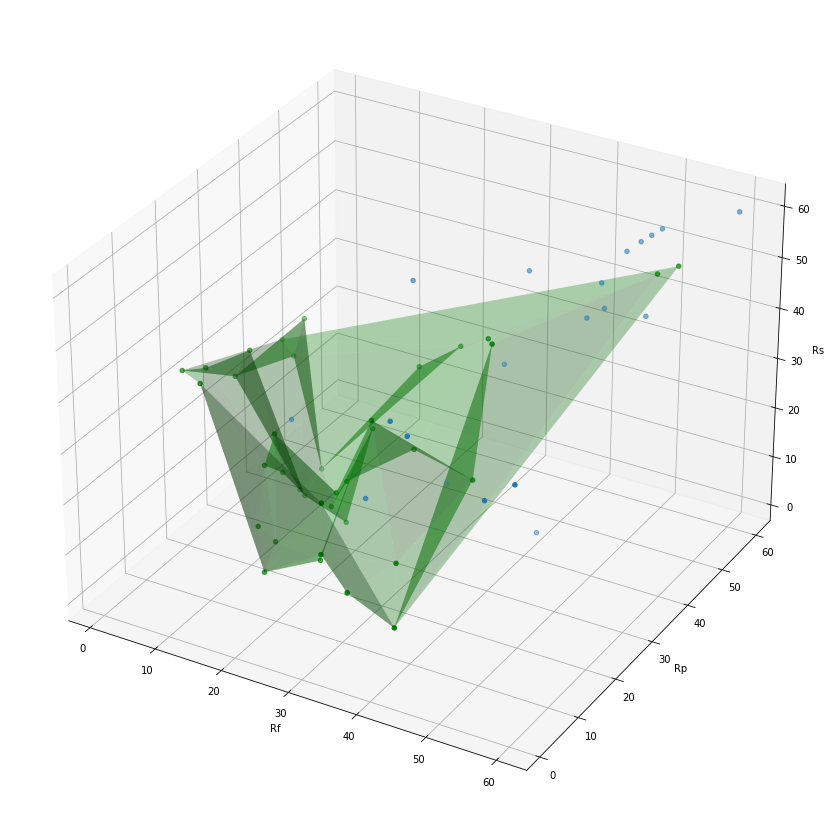

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



fig = plt.figure()
fig.set_size_inches(15, 15)
ax = fig.add_subplot(111, projection='3d')
dp = np.array(list(dominatedPoints))
pp = np.array(list(paretoPoints))

print(pp.shape,dp.shape)
ax.scatter(dp[:,0],dp[:,1],dp[:,2])
ax.scatter(pp[:,0],pp[:,1],pp[:,2],color='green')


ax.set_xlabel('Rf')
ax.set_ylabel('Rp')
ax.set_zlabel('Rs')




import matplotlib.tri as mtri
triang = mtri.Triangulation(pp[:,0],pp[:,1])
ax.plot_trisurf(triang,pp[:,2],color='green',alpha=0.3)
plt.show()

In [36]:
# CREATE DICTIONARY WITH RANKS AS KEY AND INDEX AS VALUE
def getConfs(points,orignaldf):
  point_confs = {}
  for i in range(0, len(orignaldf)):
    for val in points:
      if (list(val)==np.array(orignaldf[i][1:], dtype=np.float64).tolist()):
        point_confs[val]=orignaldf[i][0]

  return point_confs

In [37]:
def getConfsSorted(confsDict):  
  # # summing all the values using sum()
  temp1 = {val: np.sum(float(idx) for idx in val) 
            for val, key in confsDict.items()} #sum the ranks of non dominated solution
        
  # using sorted to perform sorting as required
  temp2 = sorted(temp1.items(), key = lambda ele : temp1[ele[0]],reverse=False) #sort according to the sum before
  res={}
  for key, val in temp2:
    res[key]=confsDict[key]

  #print("The sorted dictionary : " + str(res))
  return res

In [38]:
pareto = getConfs(paretoPoints, dimensionsAll)
pareto = getConfsSorted(pareto)
pareto

/var/folders/2p/1d3_p7wn1_7brj7yrtrpryw40000gn/T/ipykernel_1498/3544500913.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  temp1 = {val: np.sum(float(idx) for idx in val)


{(30.0,
  5.0,
  18.0,
  1.0,
  4.0,
  1.0,
  25.0,
  1.0,
  1.0,
  60.0,
  60.0): 'orc_wpt_subject',
 (43.0,
  1.0,
  12.0,
  4.0,
  2.0,
  2.0,
  24.0,
  3.0,
  3.0,
  60.0,
  60.0): 'parquet_wpt_subject',
 (12.0,
  25.0,
  13.0,
  46.0,
  8.0,
  11.0,
  5.0,
  34.0,
  44.0,
  19.0,
  2.0): 'parquet_vt_subject',
 (35.0,
  3.0,
  14.0,
  5.0,
  3.0,
  3.0,
  27.0,
  4.0,
  5.0,
  60.0,
  60.0): 'orc_wpt_horizontal',
 (19.0,
  9.0,
  7.0,
  32.0,
  11.0,
  14.0,
  42.0,
  19.0,
  8.0,
  2.0,
  60.0): 'parquet_extvt_subject',
 (32.0,
  2.0,
  31.0,
  2.0,
  1.0,
  4.0,
  28.0,
  2.0,
  6.0,
  60.0,
  60.0): 'parquet_wpt_horizontal',
 (15.0,
  14.0,
  11.0,
  33.0,
  6.0,
  20.0,
  46.0,
  17.0,
  7.0,
  1.0,
  60.0): 'parquet_extvt_horizontal',
 (11.0,
  32.0,
  3.0,
  11.0,
  13.0,
  6.0,
  17.0,
  6.0,
  13.0,
  60.0,
  60.0): 'parquet_pt_subject',
 (18.0,
  31.0,
  1.0,
  15.0,
  12.0,
  5.0,
  14.0,
  5.0,
  14.0,
  60.0,
  60.0): 'orc_pt_subject',
 (17.0,
  15.0,
  8.0,
  50.0,
  1

In [39]:
dominated=getConfs(dominatedPoints, dimensionsAll)
dominated = getConfsSorted(dominated)
dominated

/var/folders/2p/1d3_p7wn1_7brj7yrtrpryw40000gn/T/ipykernel_1498/3544500913.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  temp1 = {val: np.sum(float(idx) for idx in val)


{(27.0,
  42.0,
  5.0,
  20.0,
  14.0,
  9.0,
  21.0,
  9.0,
  17.0,
  60.0,
  60.0): 'avro_pt_horizontal',
 (44.0,
  36.0,
  6.0,
  16.0,
  17.0,
  10.0,
  19.0,
  10.0,
  20.0,
  60.0,
  60.0): 'avro_pt_subject',
 (33.0,
  11.0,
  26.0,
  43.0,
  21.0,
  26.0,
  53.0,
  24.0,
  11.0,
  7.0,
  60.0): 'avro_extvt_predicate',
 (56.0,
  8.0,
  40.0,
  3.0,
  18.0,
  16.0,
  29.0,
  12.0,
  22.0,
  60.0,
  60.0): 'avro_wpt_subject',
 (16.0,
  21.0,
  28.0,
  53.0,
  31.0,
  33.0,
  12.0,
  49.0,
  52.0,
  29.0,
  8.0): 'parquet_vt_predicate',
 (34.0,
  45.0,
  30.0,
  13.0,
  33.0,
  43.0,
  36.0,
  40.0,
  33.0,
  15.0,
  15.0): 'orc_st_horizontal',
 (54.0,
  4.0,
  39.0,
  6.0,
  34.0,
  31.0,
  31.0,
  13.0,
  23.0,
  60.0,
  60.0): 'avro_wpt_horizontal',
 (42.0,
  6.0,
  45.0,
  7.0,
  38.0,
  36.0,
  30.0,
  15.0,
  27.0,
  60.0,
  60.0): 'csv_wpt_subject',
 (39.0,
  7.0,
  46.0,
  8.0,
  40.0,
  37.0,
  32.0,
  16.0,
  26.0,
  60.0,
  60.0): 'csv_wpt_horizontal',
 (45.0,
  47.0,
  4